In [46]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
# Load dataset
with open('Dataset Chatbot.json') as file:
    data = json.load(file)

In [48]:
# Initialize lists
sentences = []
labels = []

In [49]:
# Extract patterns and tags
for intent in data['intents']:
    for pattern in intent['patterns']:
        sentences.append(pattern)
        labels.append(intent['tag'])

In [50]:
# Tokenization
tokenizer = Tokenizer(num_words=2000, lower=True, oov_token='OOV')
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post')

In [51]:
# Encoding labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

In [91]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, integer_encoded, test_size=0.25, random_state=42)

In [92]:
model = Sequential()
model.add(Embedding(input_dim=len(word_index)+1, output_dim=128))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(0.2))
model.add(Dense(len(set(labels)), activation='softmax'))

In [93]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='NAdam', metrics=['accuracy'])

In [94]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_chatbot_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [95]:
# Train model with validation and callbacks
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[model_checkpoint, early_stopping])

Epoch 1/100
10/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0126 - loss: 3.7604    
Epoch 1: val_accuracy improved from -inf to 0.01744, saving model to best_chatbot_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.0255 - loss: 3.7577 - val_accuracy: 0.0174 - val_loss: 3.7508
Epoch 2/100
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0823 - loss: 3.7281 
Epoch 2: val_accuracy improved from 0.01744 to 0.02326, saving model to best_chatbot_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0727 - loss: 3.7256 - val_accuracy: 0.0233 - val_loss: 3.7277
Epoch 3/100
 9/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0377 - loss: 3.6670 
Epoch 3: val_accuracy improved from 0.02326 to 0.04070, saving model to best_chatbot_model.keras
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0364 - loss: 3.6659 - val_accuracy: 0.0407 - val_loss: 3.6933
Epoch 4/100
11/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0484 - loss: 3.5645
Epoch 4: val_accura

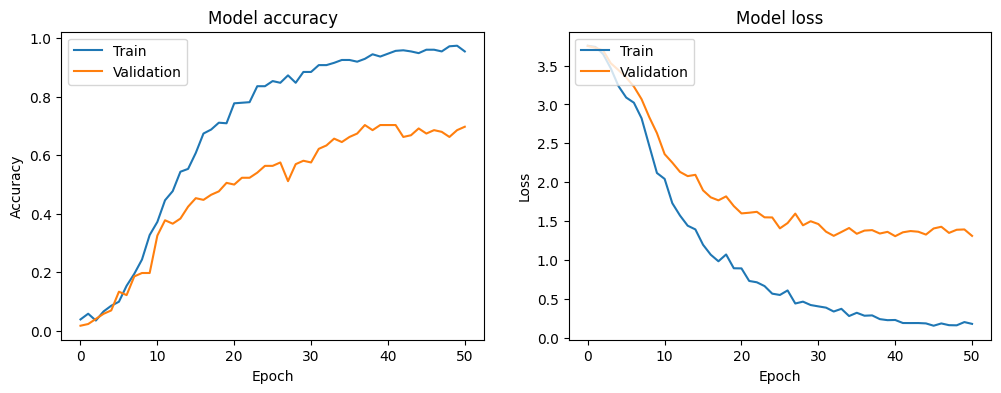

In [96]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [97]:
model.save('chatbot_model.h5')